
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  * Historical wave families 
  * Historical intradaily hydrograph parameters
  * TCs waves
  
in this notebook:
  * Fit a multivariate extreme model for the waves associated to each DWT
  * Generate synthetic time series of wave conditions
  * Validate the synthetic waves by means of mean distributions



### Workflow:

<div>
<img src="resources/nb01_12.png" width="400px">
</div>



The **synthetic generation of wave conditions on a regular climate** (DWT1-36) is based on the work of Rueda et al. 2017. The probability of SW1, SW2, and SEA components being present (1) or not present (0) at the time of observed peak TWLproxy was used to create eight potential sea-states within each DWT (000, 100, 010, 001, 110, 101, 011, 111) defined by Bernoulli distributions . For each hydrograph produced in the simulations of climate, a random pick from the appropriate Bernoulli distribution determined which sea state was present during that hydrograph. A subsequent random pick from the assigned sea state’s marginal distributions defined the waves at the maximum TWL peak within the simulated hydrograph.

The marginal distributions of waves and surge levels were associated with each other using multivariate gaussian copulas. The copulas define the dependence structure, or joint probabilities, between each environmental parameter within a sea state by identifying correlation matrices after transforming each marginal distribution to a uniform distribution. Identifying the correlation across all parameters through the copulas ensures that realistic combinations of compounding environmental parameters are present in the hypothetical time series (i.e., large storm waves approach from appropriate wave directions) (Masina et al. 2015; Corbella & Stretch, 2013). The marginal distributions of wave heights were defined by GEVs to allow for simulation of extremes with longer return periods than the observation period, while wave periods and directions were defined by empirical distributions constructed from observations. 

Additional parameters including τ (timing of the peak TWL within a hydrograph) and μ (area under the hydrograph) were also added to each copula and randomly sampled for each simulated hydrograph. The two parameters effectively define a trapezoidal shape for each simulated hydrograph, analogous to the storm schematization of other recent works (e.g., Poelhekke et al., 2016). Including these parameters in the copulas accounts for correlation between storminess and hydrograph shape (peaky hydrographs are commonly associated with storm conditions while more flat hydrographs typically occur during calmer conditions). The shape of the simulated hydrograph will be use to interpolate to an hourly value of the TWLproxy, and subsequently an hourly value of wave conditions *(notebook 14)*

In the case on **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio.




In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim


C:\Users\lcag075\AppData\Local\Continuum\anaconda2\envs\teslakit\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO')


In [3]:
## PRESSURE WIND

press=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Pressures.nc'))
wind=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Winds.nc'))
wind

<xarray.Dataset>
Dimensions:    (time: 56841)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 1980-02-04 ... 2018-12-31
Data variables:
    U          (time) float32 ...
    V          (time) float32 ...
    Dir        (time) float32 ...
    Speed      (time) float32 ...

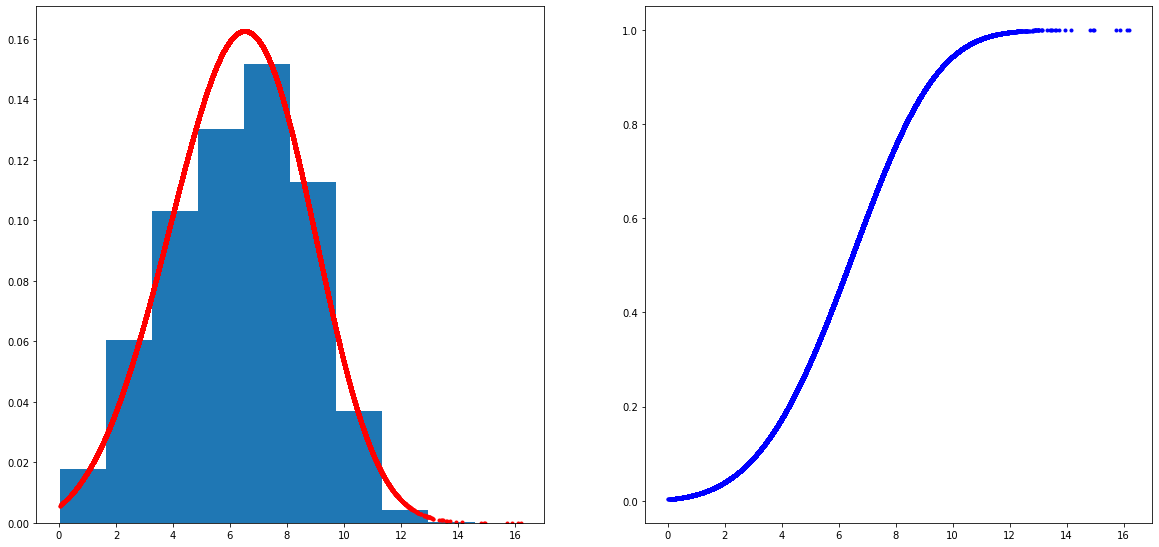

In [4]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
from matplotlib import gridspec

pdf=weibull_min.pdf(wind.Speed.values,*weibull_min.fit(wind.Speed.values))
cdf=weibull_min.cdf(wind.Speed.values,*weibull_min.fit(wind.Speed.values))

fig = plt.figure(figsize=[20,9.5])
gs2=gridspec.GridSpec(1,2)
ax1=fig.add_subplot(gs2[0])
ax1.hist(wind.Speed.values,density=True)
ax1.plot(wind.Speed,pdf,'r.')

ax1=fig.add_subplot(gs2[1])
ax1.plot(wind.Speed,cdf,'b.',)

In [5]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
# TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


In [6]:
# TODO developer, solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))



## Climate Emulator - Fitting

In [7]:
# Waves and KMA bmus data share time limits

WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

# resample extra data
WDS = wind.resample(time='1h').pad().sel(time=WVS_fit.time)
PSS = press.resample(time='1h').pad().sel(time=WVS_fit.time)

# add extra data to WAVES dataset
WVS_fit['wind_speed'] = WDS.Speed
WVS_fit['wind_dir'] = WDS.Dir
WVS_fit['msl'] = PSS.msl

In [8]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# # Fit extremes model
config = {
    'waves_families': ['sea', 'swell_1', 'swell_2', 'swell_3'],
    'extra_variables': ['wind_speed', 'wind_dir', 'msl'],
    'distribution': [
        ('sea_Tp', 'Empirical'),
        ('wind_dir', 'Empirical'),
        ('msl', 'Empirical'),
        ('wind_speed', 'Weibull'),
    ],
    'do_chromosomes': False,
}

CE.FitExtremes(DWTs_fit, WVS_fit, config)

# Load Climate Emulator (only need to Fit CE once)
# CE.Load()


Waves Families: ['sea', 'swell_1', 'swell_2', 'swell_3']
Extra Variables: ['wind_speed', 'wind_dir', 'msl']
GEV distribution: ['sea_Hs', 'swell_1_Hs', 'swell_1_Tp', 'swell_2_Hs', 'swell_2_Tp', 'swell_3_Hs', 'swell_3_Tp']
Empirical distribution: ['sea_Dir', 'swell_1_Dir', 'swell_2_Dir', 'swell_3_Dir', 'sea_Tp', 'wind_dir', 'msl']
Weibull distribution: ['wind_speed']
Do chromosomes combinations: False


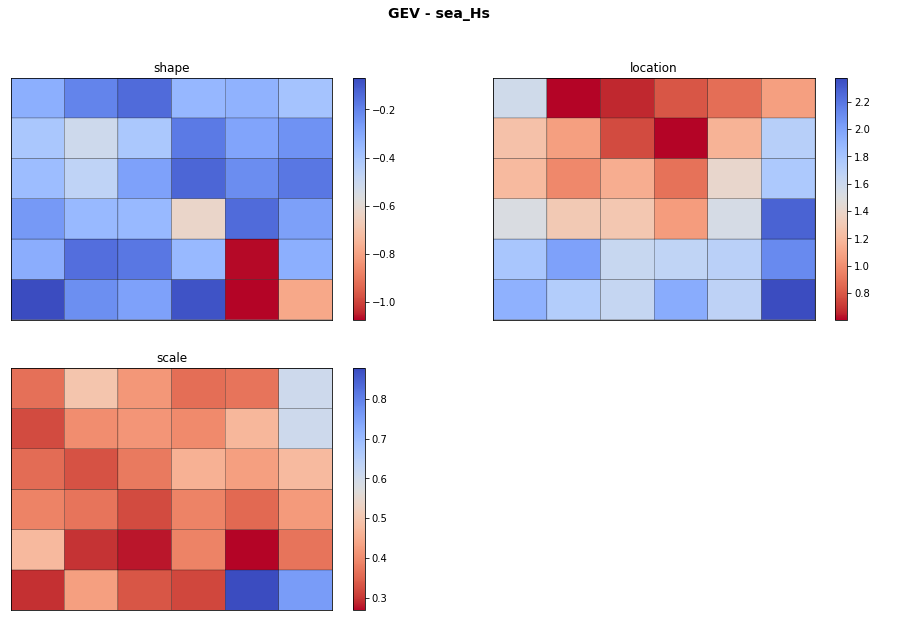

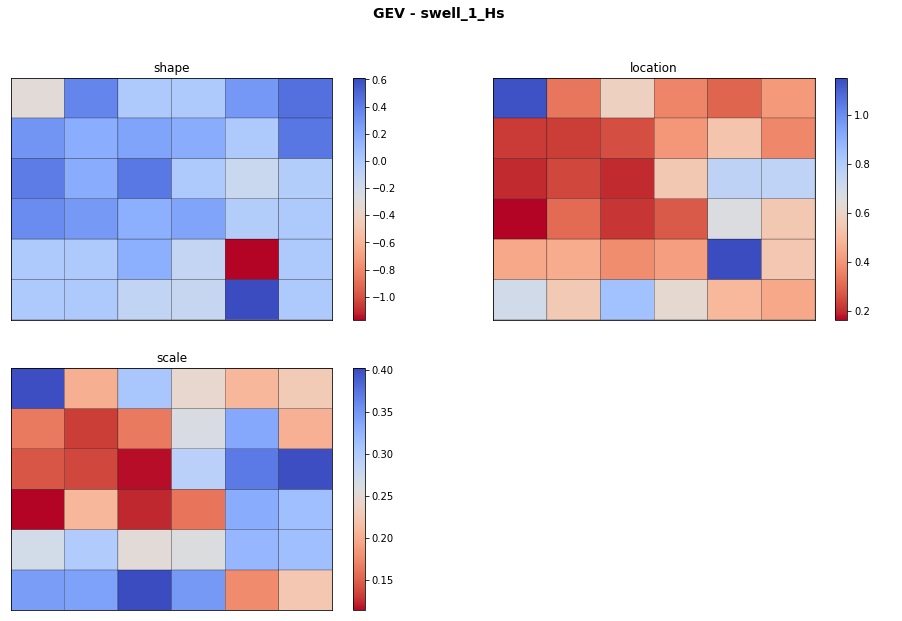

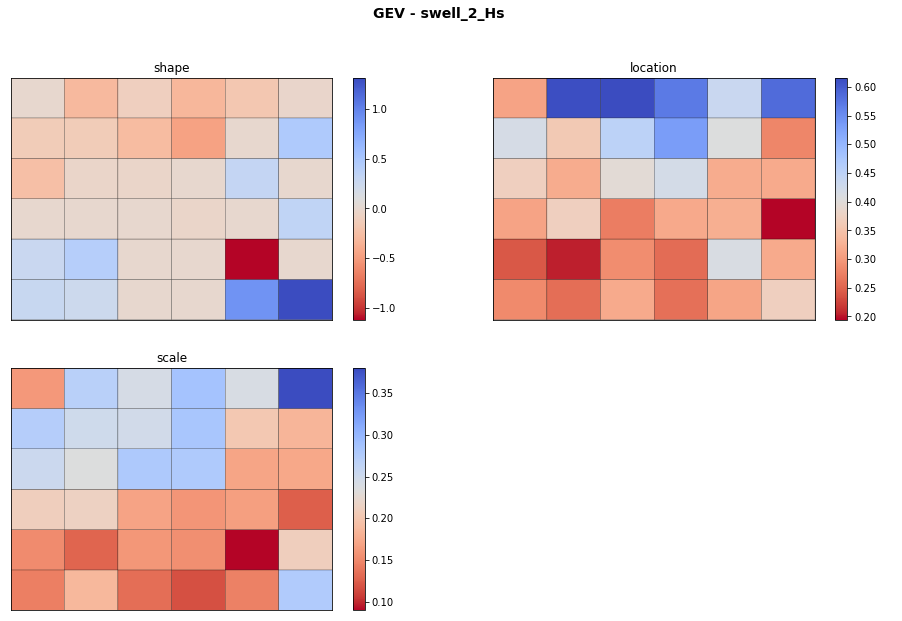

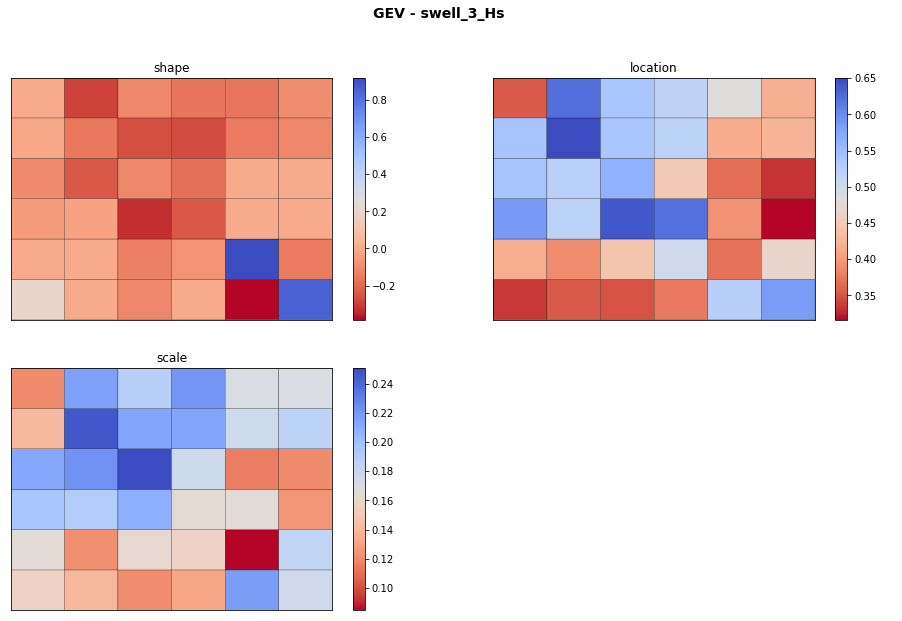

KeyError: '1111'

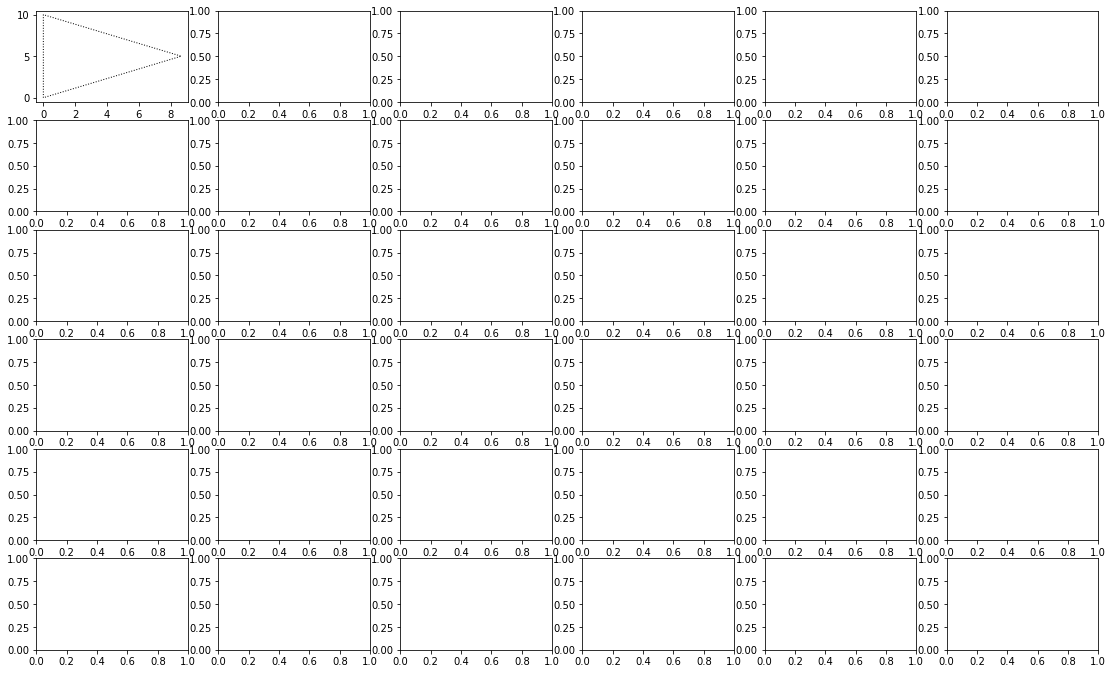

In [9]:
# Fit report figures

CE.Report_Fit();



## Climate Emulator - Simulation

In [10]:
# --------------------------------------
#  Climate Emulator simulation

# dwtsim2=DWTs_sim.isel(time=np.arange(0,1500)) ## CORTO PARA PROBAR

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
#     DWTs = dwtsim2.sel(n_sim=n)
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':False})
    #WVS_sim, _, _ = CE.LoadSim(n_sim = int(n))

    # Simulate TCs and update simulated waves
#     TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)
    TCs_sim, WVS_upd = CE.Simulate_TCs_NoEnter(DWTs, WVS_sim, TCs_params, pchange_TCs, MU_WT, TAU_WT)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
#     CE.SaveSim_wavesonly(WVS_sim, int(n))
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|████████████████████████████████████████████████████████| 85227/85227 [00:00<00:00, 96081.21it/s]


- Sim: 2 -


C.E: Sim. Waves:   0%|                                                           | 131/85073 [00:17<3:03:18,  7.72it/s]

KeyboardInterrupt: 

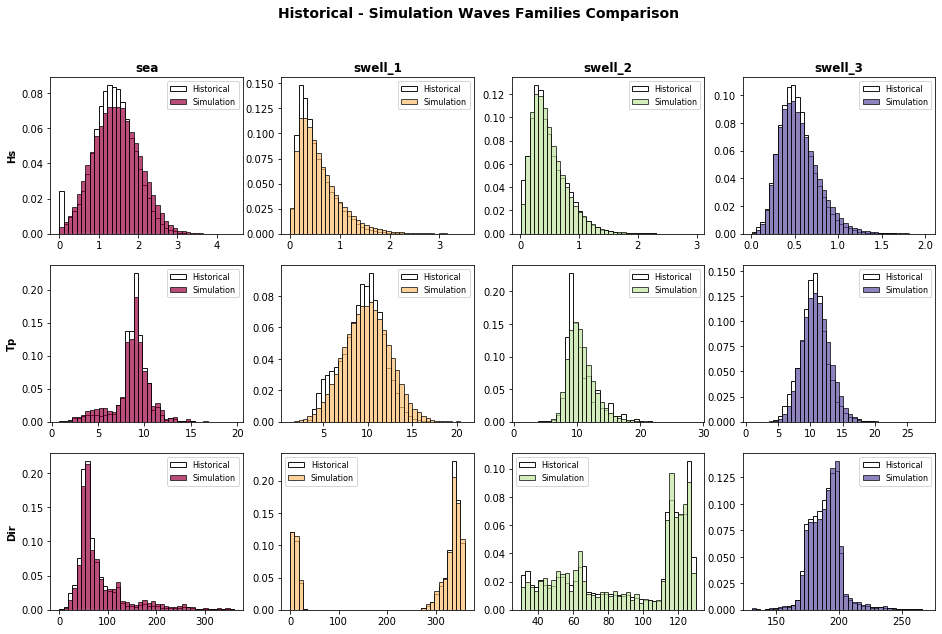

In [11]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)
# WVS_sim = CE.LoadSim_onlywaves(n_sim = n_sim_DWTs)

# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim = n_sim_CE));
# Plot_Waves_Histogram_FitSim(WVS_fit, WVS_sim.isel(n_sim = n_sim_CE));

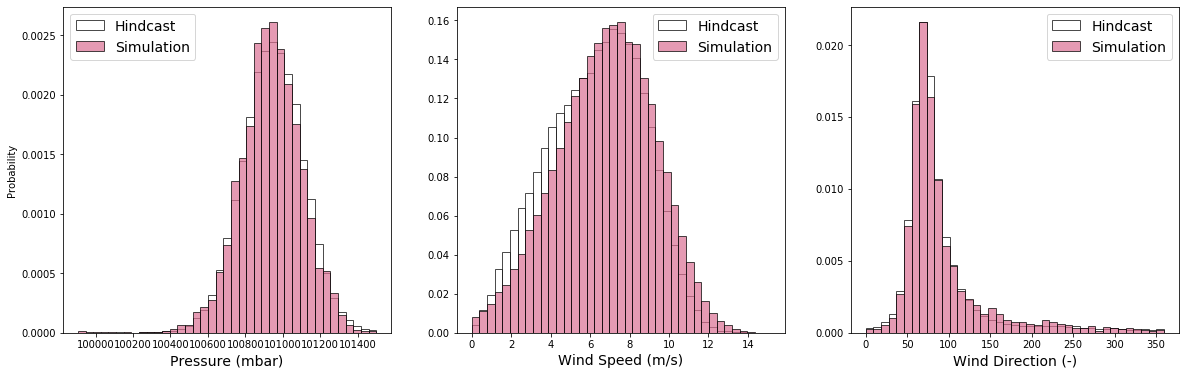

In [12]:
fig = plt.figure(figsize=[20,6])
gs2=gridspec.GridSpec(1,3)
ax1=fig.add_subplot(gs2[0])
ax1.hist(WVS_fit.msl,bins=np.linspace(np.nanmin(WVS_sim.msl),np.nanmax(WVS_sim.msl),40), density=True,color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(WVS_sim.msl,bins=np.linspace(np.nanmin(WVS_sim.msl),np.nanmax(WVS_sim.msl),40), density=True,color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Pressure (mbar)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

ax2=fig.add_subplot(gs2[1])
ax2.hist(WVS_fit.wind_speed,bins=np.linspace(np.nanmin(WVS_sim.wind_speed),np.nanmax(WVS_sim.wind_speed),40), density=True,color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax2.hist(WVS_sim.wind_speed,bins=np.linspace(np.nanmin(WVS_sim.wind_speed),np.nanmax(WVS_sim.wind_speed),40), density=True,color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax2.set_xlabel('Wind Speed (m/s)',fontsize=14)
ax2.legend(fontsize=14)

ax3=fig.add_subplot(gs2[2])
ax3.hist(WVS_fit.wind_dir,bins=np.linspace(np.nanmin(WVS_sim.wind_dir),np.nanmax(WVS_sim.wind_dir),40), density=True,color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax3.hist(WVS_sim.wind_dir,bins=np.linspace(np.nanmin(WVS_sim.wind_dir),np.nanmax(WVS_sim.wind_dir),40), density=True,color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax3.set_xlabel('Wind Direction (­)',fontsize=14)
ax3.legend(fontsize=14)

In [17]:
n_sim_DWTs=0

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
WVS_sim = CE.LoadSim_onlywaves(n_sim = n_sim_DWTs)
WVS = db.Load_WAVES_hist()      # Historical gow waves point

def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

WVS_y=WVS.resample(time='1Y').max()
WVS_sim_y=WVS_sim.resample(time='1Y').max()

# RP calculation, var sorting historical
t_h = t_rp(WVS_y.time.dt.year)
t_s = t_rp(WVS_sim_y.time.dt.year)

Text(0, 0.5, 'Return Period (Years)')

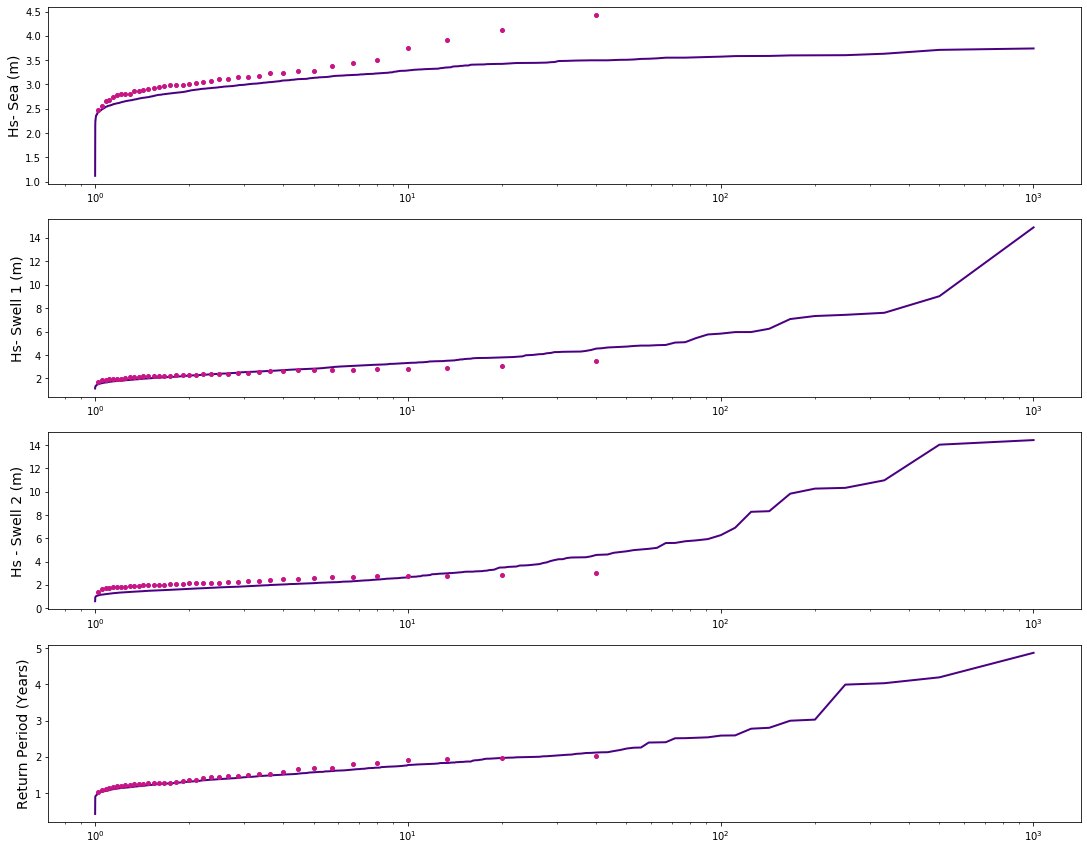

In [18]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.figure(figsize=[18.5,15])
gs1=gridspec.GridSpec(4,1)
ax=fig.add_subplot(gs1[0])
ax1=fig.add_subplot(gs1[1])
ax2=fig.add_subplot(gs1[2])
ax3=fig.add_subplot(gs1[3])

ax.semilogx(t_h, np.sort(WVS_y.sea_Hs.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax.semilogx(t_s, np.sort(WVS_sim_y.sea_Hs.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax.set_ylabel('Hs- Sea (m)',fontsize=14)

ax1.semilogx(t_h, np.sort(WVS_y.swell_1_Hs.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax1.semilogx(t_s, np.sort(WVS_sim_y.swell_1_Hs.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax1.set_ylabel('Hs- Swell 1 (m)',fontsize=14)

ax2.semilogx(t_h, np.sort(WVS_y.swell_2_Hs.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax2.semilogx(t_s, np.sort(WVS_sim_y.swell_2_Hs.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax2.set_ylabel('Hs - Swell 2 (m)',fontsize=14)

ax3.semilogx(t_h, np.sort(WVS_y.swell_3_Hs.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax3.semilogx(t_s, np.sort(WVS_sim_y.swell_3_Hs.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax3.set_ylabel('Hs - Swell 3 (m)',fontsize=14)
ax3.set_xlabel('Return Period (Years)',fontsize=14)

Text(0, 0.5, 'Return Period (Years)')

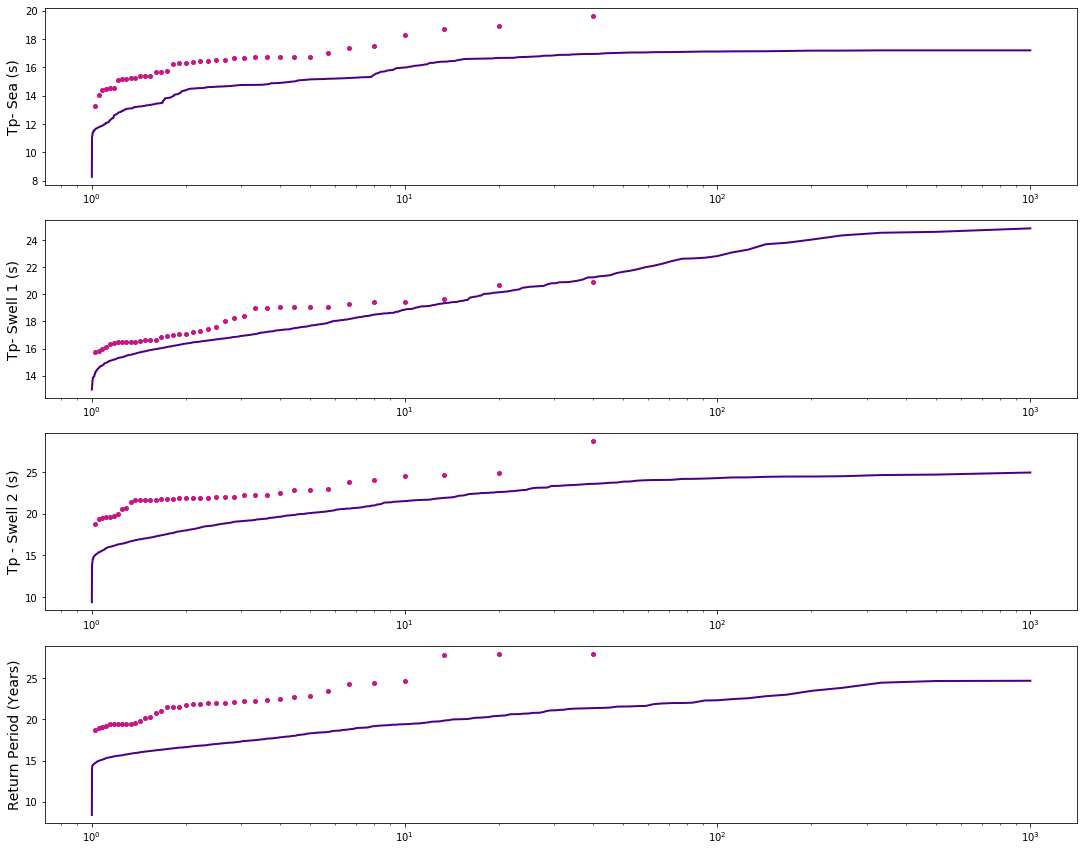

In [19]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.figure(figsize=[18.5,15])
gs1=gridspec.GridSpec(4,1)
ax=fig.add_subplot(gs1[0])
ax1=fig.add_subplot(gs1[1])
ax2=fig.add_subplot(gs1[2])
ax3=fig.add_subplot(gs1[3])

ax.semilogx(t_h, np.sort(WVS_y.sea_Tp.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax.semilogx(t_s, np.sort(WVS_sim_y.sea_Tp.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax.set_ylabel('Tp- Sea (s)',fontsize=14)

ax1.semilogx(t_h, np.sort(WVS_y.swell_1_Tp.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax1.semilogx(t_s, np.sort(WVS_sim_y.swell_1_Tp.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax1.set_ylabel('Tp- Swell 1 (s)',fontsize=14)

ax2.semilogx(t_h, np.sort(WVS_y.swell_2_Tp.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax2.semilogx(t_s, np.sort(WVS_sim_y.swell_2_Tp.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax2.set_ylabel('Tp - Swell 2 (s)',fontsize=14)

ax3.semilogx(t_h, np.sort(WVS_y.swell_3_Tp.values), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax3.semilogx(t_s, np.sort(WVS_sim_y.swell_3_Tp.values[:,n_sim_DWTs]), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax3.set_ylabel('Tp - Swell 3 (s)',fontsize=14)
ax3.set_ylabel('Return Period (Years)',fontsize=14)

In [20]:
from teslakit.waves import Aggregate_WavesFamilies

# aggregate waves families
WVS_agr = Aggregate_WavesFamilies(WVS)

In [21]:
WVS_sim=WVS_sim.sel(n_sim=0)

In [22]:
WVS_sim_agr = Aggregate_WavesFamilies(WVS_sim)

In [23]:
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

WVS_y=WVS_agr.resample(time='1Y').max()
WVS_sim_y=WVS_sim_agr.resample(time='1Y').max()

# RP calculation, var sorting historical
t_h = t_rp(WVS_y.time.dt.year)

In [24]:
WVS_sim_y

<xarray.Dataset>
Dimensions:  (time: 1001)
Coordinates:
  * time     (time) object 2000-12-31 00:00:00 ... 3000-12-31 00:00:00
Data variables:
    Hs       (time) float32 3.255208 3.022049 3.4286451 ... 9.088264 1.7531898
    Tp       (time) float32 13.212398 12.621712 14.572045 ... 12.982092 9.91164
    Dir      (time) float32 355.81366 352.5051 357.12927 ... 353.09235 20.149792

Text(0.5, 0, 'Return Period (Years)')

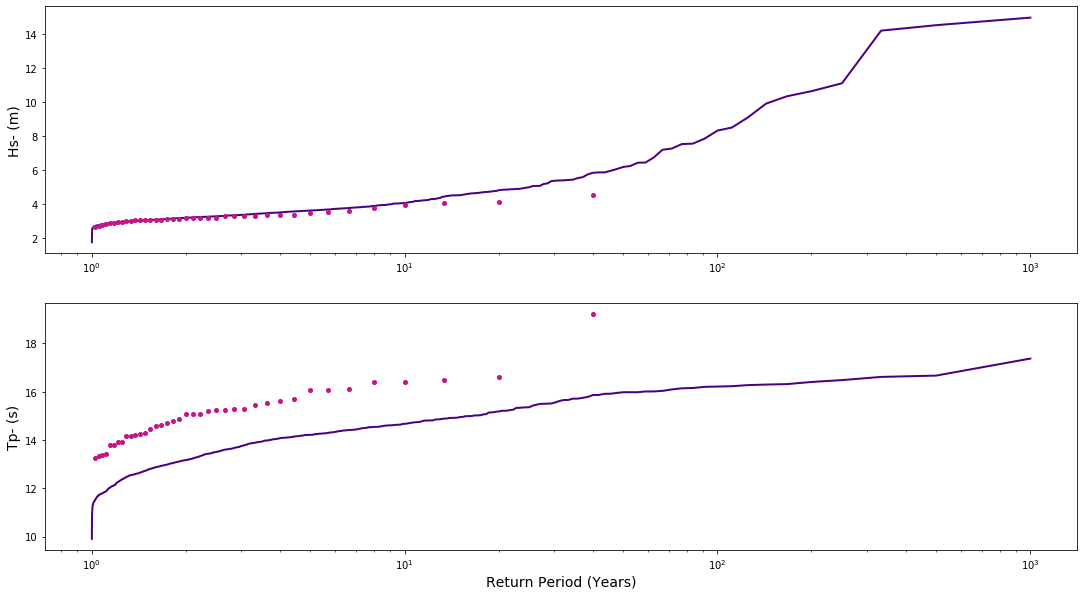

In [25]:
fig = plt.figure(figsize=[18.5,10])
gs1=gridspec.GridSpec(2,1)
ax=fig.add_subplot(gs1[0])
ax1=fig.add_subplot(gs1[1])


ax.semilogx(t_h, np.sort(WVS_y.Hs), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax.semilogx(t_s, np.sort(WVS_sim_y.Hs), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax.set_ylabel('Hs- (m)',fontsize=14)

ax1.semilogx(t_h, np.sort(WVS_y.Tp), 'ok',color='mediumvioletred', markersize = 4, label = 'Historical', zorder=9,)
ax1.semilogx(t_s, np.sort(WVS_sim_y.Tp), '-',color='indigo', linewidth = 2, label = 'Simulation (mean)',  zorder=8,)
ax1.set_ylabel('Tp- (s)',fontsize=14)
ax1.set_xlabel('Return Period (Years)',fontsize=14)